In [4]:
import sys
sys.path.append("..")

# Car Tracking Example

Track car state with Kalman filter and Rauch-Tung-Striebel
smoother as in Examples 6.8 and 12.4 of the book

_Simo Särkkä and Lennart Svensson (2023), Bayesian Filtering and Smoothing, 2nd ed., Cambridge University Press._

See LICENSE provided with the software.

## Imports

### Standard imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import json
from scipy import linalg


### Helpers imports

In [6]:
from common_utilities import generate_ssm, RandomState, rmse, plot_car_trajectory

## Routine

Set the parameters:

In [7]:
q = 1.
dt = 0.1
s = 0.5

M = 4  # State dimension
N = 2  # Observation dimension

In [8]:
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

In [9]:
Q = q * np.array([[dt ** 3 / 3, 0, dt ** 2 / 2, 0],
                  [0, dt **3 / 3, 0, dt ** 2 / 2],
                  [dt ** 2 / 2, 0, dt, 0],
                  [0, dt ** 2 / 2, 0, dt]])

In [10]:
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

In [11]:
R = np.array([[s ** 2, 0],
              [0, s ** 2]])

In [12]:
x_0 = np.array([0., 0., 1., -1.])

## Load or simulate data

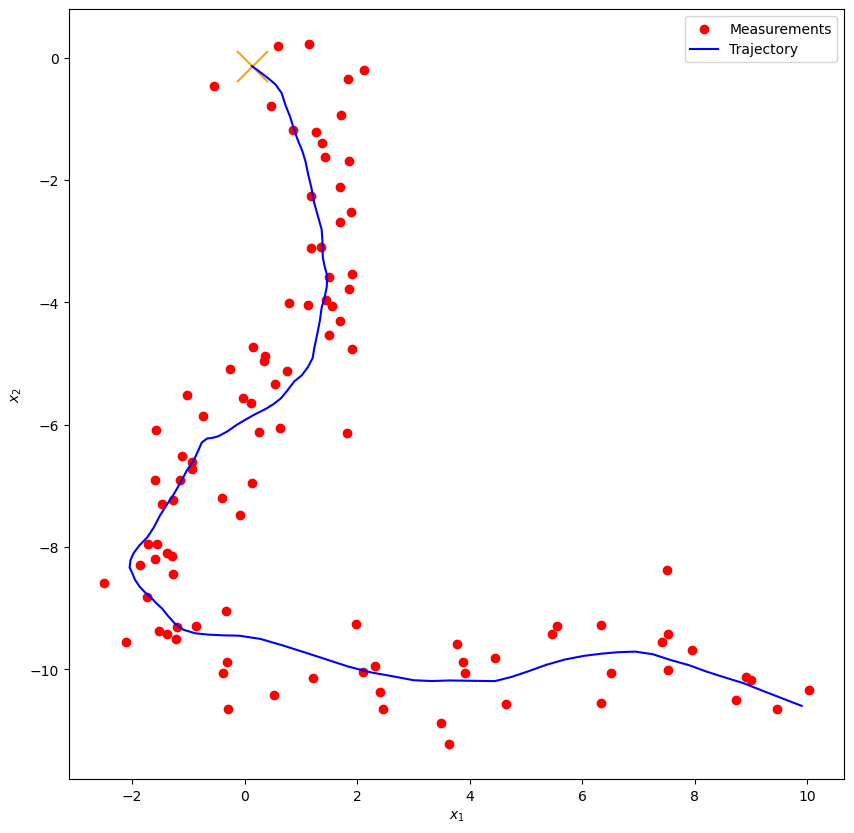

In [13]:
# This is simulation
#random_state = RandomState(6)
#steps = 100
#states, observations = generate_ssm(x_0, A, Q, H, R, steps, random_state)

# This loads stored data from file
with open("car_track.json") as fp:
    jsondata = json.load(fp)
    states = np.array(jsondata["X"]).T
    observations = np.array(jsondata["Y"]).T
    steps = states.shape[0]

plot_car_trajectory(observations, states, "Trajectory")

## Kalman Filter

In [14]:
def kalman_filter(m_0, P_0, A, Q, H, R, observations):
    M = m_0.shape[-1]
    steps, N = observations.shape
    
    kf_m = np.empty((steps, M))
    kf_P = np.empty((steps, M, M))
    
    m = m_0
    P = P_0
    
    for i in range(steps):
        y = observations[i]
        m = A @ m
        P = A @ P @ A.T + Q
        
        S = H @ P @ H.T + R
        # More efficient and stable way of computing K = P @ H.T @ linalg.inv(S)
        # This also leverages the fact that S is known to be a positive definite matrix (assume_a="pos")
        K = linalg.solve(S.T, H @ P, assume_a="pos").T 
        
        m = m + K @ (y - H @ m)
        P = P - K @ S @ K.T
        
        kf_m[i] = m
        kf_P[i] = P
    return kf_m, kf_P

## RTS Smoother

In [15]:
def rts_smoother(kf_m, kf_P, A, Q):
    steps, M = kf_m.shape
    
    rts_m = np.empty((steps, M))
    rts_P = np.empty((steps, M, M))
    
    m = kf_m[-1]
    P = kf_P[-1]
    
    rts_m[-1] = m
    rts_P[-1] = P
    
    for i in range(steps-2, -1, -1):
        filtered_m = kf_m[i]
        filtered_P = kf_P[i]
        
        mp = A @ filtered_m
        Pp = A @ filtered_P @ A.T + Q

        # More efficient and stable way of computing Gk = filtered_P @ A.T @ linalg.inv(Pp)
        # This also leverages the fact that Pp is known to be a positive definite matrix (assume_a="pos")
        Gk = linalg.solve(Pp, A @ filtered_P, assume_a="pos").T 

        m = filtered_m + Gk @ (m - mp)
        P = filtered_P + Gk @ (P - Pp) @ Gk.T
        
        rts_m[i] = m
        rts_P[i] = P

    return rts_m, rts_P

In [16]:
rts_m, rts_P = rts_smoother(kf_m, kf_P, A, Q)

plot_car_trajectory(observations, states, "Trajectory", rts_m, "Smoother Estimate")

rmse_rts = rmse(states[:, :2], rts_m[:, :2])
print(f"RTS RMSE: {rmse_rts}")

NameError: name 'kf_m' is not defined

In [30]:
dt = 0.1
A = np.array([[1, 0, dt,  0],
              [0, 1,  0, dt],
              [0, 0,  1,  0],
              [0, 0,  0,  1]])
x0 = np.array([0, 0, 1, 0.5])
steps = 100

def true_states_generate(x0, A, steps):
    x = np.zeros((steps, len(x0)))
    x[0] = x0
    for i in range(1, steps):
        x[i] = A @ x[i - 1]
    return x

true_states = true_states_generate(x0, A, steps)

In [60]:
threshold = 1

In [54]:
def delta_trigger(observations, threshold):
    
    #creating an output array with NaNs for the skipped steps
    masked_obs = np.full_like(observations, np.nan)
    
    #List of time indices where the trigger occurs
    trigger_indices = []

    last_sent = observations[0]
    masked_obs[0] = last_sent
    trigger_indices.append(0)
    
    for t in range (1, len(observations)): 
        dist = np.linalg.norm(observations[t] - last_sent)
        if dist> threshold:
            masked_obs[t] = observations[t]
            trigger_indices.append(t)
            last_sent = observations[t]
    
    return masked_obs, trigger_indices
    
#threshold = 1.5
filtered_obs, triggered_steps = delta_trigger(observations, threshold)
valid = ~np.isnan(filtered_obs[:, 0])
triggered_points = filtered_obs[valid]

In [55]:
valid_delta = ~np.isnan(filtered_obs[:, 0])
triggered_coords = filtered_obs[valid_delta]

from scipy.interpolate import splprep, splev
from scipy.interpolate import interp1d

time_all = np.arange(steps)
time_delt_triggered = time_all[valid_delta]
interp_x = interp1d(time_delt_triggered, triggered_coords[:, 0], kind='linear', fill_value='extrapolate')
interp_y = interp1d(time_delt_triggered, triggered_coords[:, 1], kind='linear', fill_value='extrapolate')
est_x = interp_x(time_all)
est_y = interp_y(time_all)
estimated_line = np.column_stack([est_x, est_y])

In [56]:
if len(triggered_points) >= 4:
    # Prepare spline fit
    tck, _ = splprep([triggered_points[:, 0], triggered_points[:, 1]], s=0)
    u_fine = np.linspace(0, 1, 300)
    x_smooth, y_smooth = splev(u_fine, tck)
    smooth_traj = np.column_stack([x_smooth, y_smooth])
else:
    smooth_traj = triggered_points  # fallback if not enough points

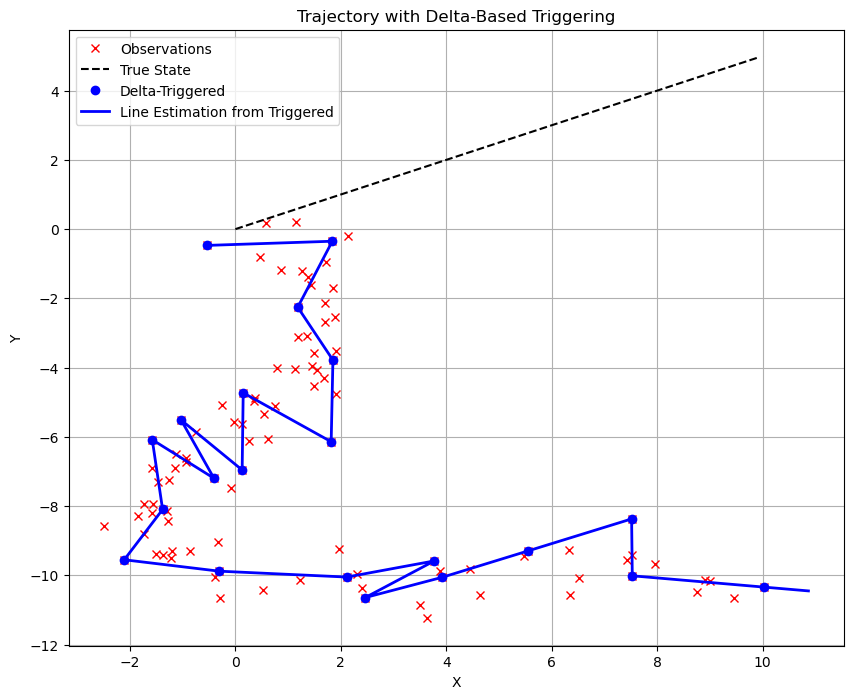

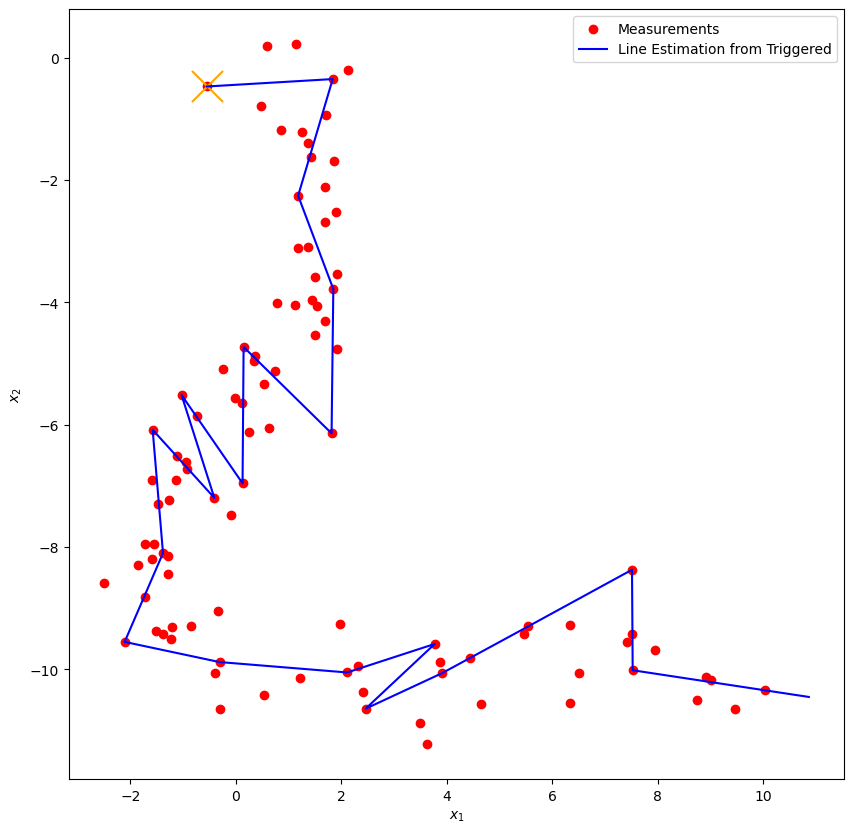

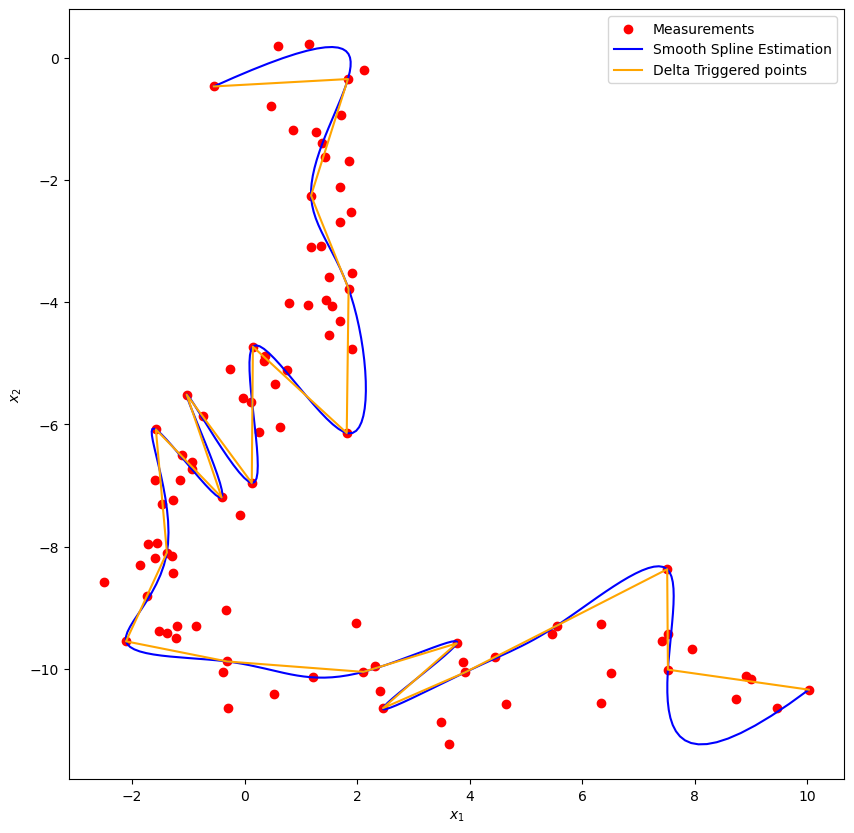

In [57]:

valid = ~np.isnan(filtered_obs[:, 0])

plt.figure(figsize=(10, 8))
plt.plot(observations[:, 0], observations[:, 1], 'rx', label='Observations')           # all raw observations
plt.plot(true_states[:, 0], true_states[:, 1], 'k--', label='True State')              # true state path
plt.plot(filtered_obs[valid, 0], filtered_obs[valid, 1], 'bo', label='Delta-Triggered')  # triggered observations
plt.plot(est_x, est_y, 'b-', linewidth=2, label='Line Estimation from Triggered')
plt.title("Trajectory with Delta-Based Triggering")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

plot_car_trajectory(
    y=observations,
    x1=estimated_line,
    label1="Line Estimation from Triggered"
)


plot_car_trajectory(
    y = observations,
    
    x1 = smooth_traj,
    label1 = "Smooth Spline Estimation",
    
    x2 = triggered_points,
    label2 = "Delta Triggered points"
    
)

In [81]:
innovthreshold = 1.5

In [82]:
dt = 0.1
steps = 100
A = np.array([[1, 0, dt,  0],
              [0, 1,  0, dt],
              [0, 0,  1,  0],
              [0, 0,  0,  1]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

Q = np.diag([1e-4, 1e-4, 1e-3, 1e-3])

R = np.diag([0.5, 0.5])

x0 = np.array([0, 0, 1, 0.5])

P0 = np.eye(4)




def innovation_triggering(observations, A, H, Q, R, x0, P0, threshold):
    steps = len(observations)
    dim = len(x0)
    
    x_pred = x0.copy()
    P = P0.copy()
    
    masked_obs = np.full_like(observations, np.nan)
    trigger_indices = []
    
    for t in range(steps):
        x_pred = A @ x_pred
        P = A @ P @ A.T + Q
    
        y = observations[t]
        y_hat = H @ x_pred
        residual = y - y_hat
        S = H @ P @ H.T + R
        residual_norm = np.linalg.norm(residual)
        
        if residual_norm > threshold:
            masked_obs[t] = y
            trigger_indices.append(t)
            
            #update portion for kalman filter
            K = P @ H.T @ np.linalg.inv(S)
            x_pred = x_pred + K @ residual
            P = (np.eye(dim) - K @ H) @ P
            

    return masked_obs, trigger_indices

obs_innov, idx_innov = innovation_triggering(
    observations, A, H, Q, R, x0, P0, threshold
)
valid_innov = ~np.isnan(obs_innov[:, 0])
triggeredinnovpoints = obs_innov[valid_innov]

#smooth spline
if len(triggeredinnovpoints) >= 4:
    tck, _ = splprep([triggeredinnovpoints[:, 0], triggeredinnovpoints[:, 1]], s=0)
    u_fine = np.linspace(0, 1, 300)
    x_smooth, y_smooth = splev(u_fine, tck)
    smoothinnovtraj = np.column_stack([x_smooth, y_smooth])
else:
    smoothinnovtraj = triggeredinnovpoints

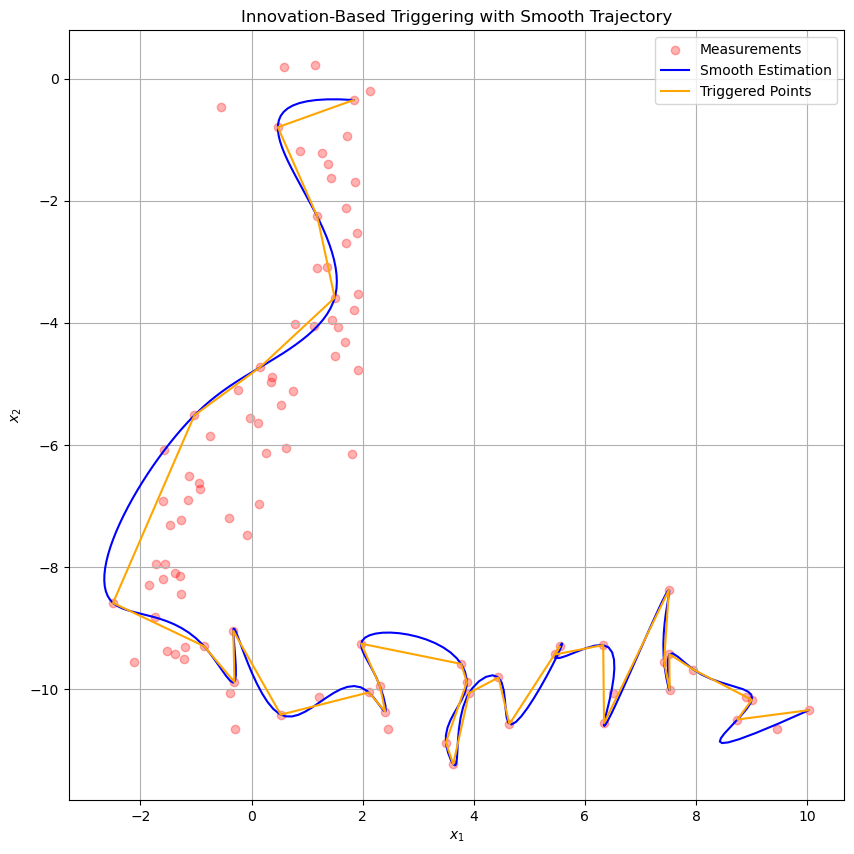

In [83]:


plt.figure(figsize=(10, 10))
plt.scatter(observations[:, 0], observations[:, 1], color='red', alpha=0.3, label='Measurements')
plt.plot(smoothinnovtraj[:, 0], smoothinnovtraj[:, 1], color='blue', label='Smooth Estimation')
plt.plot(triggeredinnovpoints[:, 0], triggeredinnovpoints[:, 1], color='orange', label='Triggered Points')
plt.xlabel("${\it x}_1$")
plt.ylabel("${\it x}_2$")
plt.legend()
plt.title("Innovation-Based Triggering with Smooth Trajectory")
plt.grid(True)
plt.show()

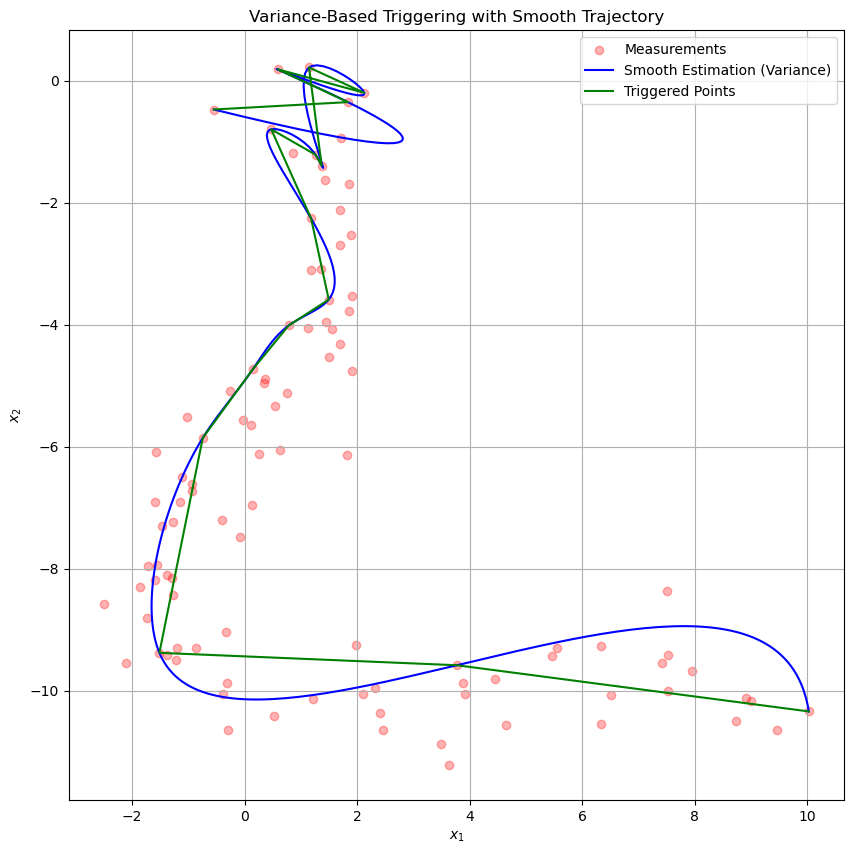

In [84]:
def variance_trigger(observations, A, H, Q, R, x0, P0, threshold):
    steps = len(observations)
    dim = len(x0)
    x_pred = x0.copy()
    P = P0.copy()
    
    masked_obs = np.full_like(observations, np.nan)
    trigger_indices = []
    
    for t in range(steps):
        x_pred = A @ x_pred
        P = A @ P @ A.T + Q
        
        if np.trace(P) > threshold:
            y = observations[t]
            masked_obs[t] = y
            trigger_indices.append(t)
            
            
            #update part
            y_hat = H @ x_pred
            residual = y - y_hat
            S = H @ P @ H.T + R
            K = P @ H.T @ np.linalg.inv(S)
            x_pred = x_pred + K @ residual
            P = (np.eye(dim) - K @ H) @ P

    return masked_obs, trigger_indices 


filtered_obs_var, triggered_steps_var = variance_trigger(observations, A, H, Q, R, x0, P0, threshold)
valid_var = ~np.isnan(filtered_obs_var[:, 0])
triggered_points_var = filtered_obs_var[valid_var]

if len(triggered_points_var) >= 4:
    tck, _ = splprep([triggered_points_var[:, 0], triggered_points_var[:, 1]], s=0)
    u_fine = np.linspace(0, 1, 300)
    x_smooth_var, y_smooth_var = splev(u_fine, tck)
    smoothvartraj = np.column_stack([x_smooth_var, y_smooth_var])
else:
    smoothvartraj = triggered_points_var

    
plt.figure(figsize=(10, 10))
plt.scatter(observations[:, 0], observations[:, 1], color='red', alpha=0.3, label='Measurements')
plt.plot(smoothvartraj[:, 0], smoothvartraj[:, 1], color='blue', label='Smooth Estimation (Variance)')
plt.plot(triggered_points_var[:, 0], triggered_points_var[:, 1], color='green', label='Triggered Points')
plt.xlabel("${\it x}_1$")
plt.ylabel("${\it x}_2$")
plt.legend()
plt.title("Variance-Based Triggering with Smooth Trajectory")
plt.grid(True)
plt.show()